In [148]:
import pandas as pd
import yfinance as yf

def to_timezone_naive(datetime_series):
    return datetime_series.dt.tz_localize(None)

def get_month_end_data(df, date_column='Date'):
    df = df.copy()
    df[date_column] = to_timezone_naive(pd.to_datetime(df[date_column]))
    df = df.sort_values(by=date_column)
    df['YearMonth'] = df[date_column].dt.to_period('M')
    monthly_df = df.groupby('YearMonth').last()
    monthly_df.reset_index(inplace=True)
    monthly_df[date_column] = monthly_df['YearMonth'].dt.strftime('%Y-%m')
    monthly_df.drop('YearMonth', axis=1, inplace=True)
    return monthly_df

def download_and_process_financial_data(ticker, start_date, end_date, column_name):
    data = yf.download(ticker, start=start_date, end=end_date)['Close'].reset_index()
    data = get_month_end_data(data)
    data = data.rename(columns={'Close': column_name})
    return data

def calculate_yield_curve_slope(tbill_3_month, tbill_10_yr):
    ycurve_slope = tbill_10_yr['10 Year T-Bill Rate'] - tbill_3_month['3 Month T-Bill Rate']
    return pd.DataFrame({'Date': tbill_3_month['Date'], 'Yield Curve Slope': ycurve_slope})

def process_reer_data(filepath):
    reer_data = pd.read_excel(filepath, header=10)
    reer_data = reer_data[['observation_date', 'RBUSBIS']].rename(columns={'observation_date': 'Date'})
    reer_data['Reer Change'] = reer_data['RBUSBIS'].pct_change()
    return get_month_end_data(reer_data, 'Date')[['Date', 'Reer Change']]

def process_cpi_data(filepath):
    cpi_data = pd.read_csv(filepath)
    cpi_data = cpi_data[cpi_data['LOCATION'] == 'USA']
    cpi_data = cpi_data.rename(columns={'TIME': 'Date', 'Value': 'CPI'})
    return get_month_end_data(cpi_data[['Date', 'CPI']], 'Date')

# Download and process financial data
short_term_interest = download_and_process_financial_data('^IRX', '2005-12-01', '2023-08-01', '3 Month T-Bill Rate')
long_term_interest = download_and_process_financial_data('^TNX', '2005-12-01', '2023-08-01', '10 Year T-Bill Rate')
oil_price = download_and_process_financial_data('CL=F', '2005-12-01', '2023-08-01', 'Oil Price')
oil_price['Change Oil Price'] = oil_price['Oil Price'].pct_change()

# Calculate the yield curve slope
ycurve_slope = calculate_yield_curve_slope(short_term_interest, long_term_interest)

# Process REER and CPI data
reer_data = process_reer_data('dollar_reer.xls')
us_cpi_data = process_cpi_data('cpi.csv')

# Merge all dataframes on the Date column
macro_df = (short_term_interest.merge(ycurve_slope, on='Date', how='left')
                               .merge(reer_data, on='Date', how='left')
                               .merge(oil_price[['Date', 'Change Oil Price']], on='Date', how='left')
                               .merge(us_cpi_data, on='Date', how='left')
                               .dropna())

display(macro_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI
1,2006-01,4.370,0.157,-0.009324,0.112713,3.985317
2,2006-02,4.507,0.040,0.001604,-0.095848,3.597497
3,2006-03,4.515,0.338,0.006086,0.085002,3.362649
4,2006-04,4.650,0.419,-0.002866,0.078793,3.545735
5,2006-05,4.715,0.398,-0.017775,-0.008208,4.166667
...,...,...,...,...,...,...
207,2023-03,4.585,-1.091,0.005933,-0.017911,4.984974
208,2023-04,4.923,-1.471,-0.008239,0.014669,4.930320
209,2023-05,5.248,-1.611,0.007552,-0.113181,4.047609
210,2023-06,5.153,-1.334,0.004591,0.037450,2.969178


<AxesSubplot:>

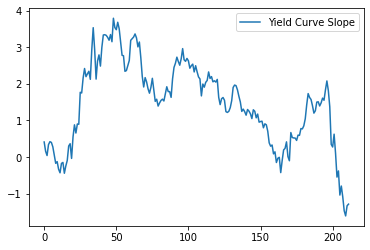

In [140]:
ycurve_slope.plot()